In [1]:
import sys
from agents.agent import DDPG_Agent
from tasks.task import Task
from tasks.takeoff_task import TakeOffTask
from plotter import Plotter
import numpy as np

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Modify the values below to give the quadcopter a different starting position.
init_pose = np.array([0., 0., 100., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = TakeOffTask(target_pos=target_pos)
agent = DDPG_Agent(task) 
avg_episode_rewards = []
episode_rewards = []

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done, is_learning = True)
        state = next_state
        if done:
            avg_episode_rewards.append(agent.score)
            episode_rewards.append(agent.total_reward)
            print("\rEpisode = {:4d}, avg_reward = {:7.3f}, reward = {:7.3f}".format(i_episode, agent.score, agent.total_reward), end="")
            break
    sys.stdout.flush()

Episode = 1000, avg_reward =   0.990, reward = 248.487

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

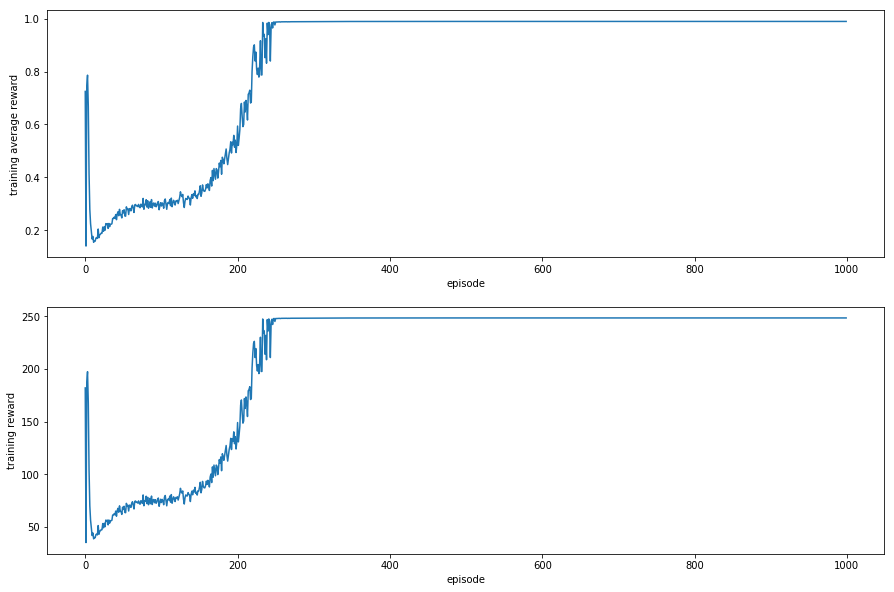

In [4]:
plt.subplots(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(avg_episode_rewards)
plt.xlabel('episode')
plt.ylabel('training average reward')

plt.subplot(2, 1, 2)
plt.plot(episode_rewards)
plt.xlabel('episode')
plt.ylabel('training reward')

plt.show()

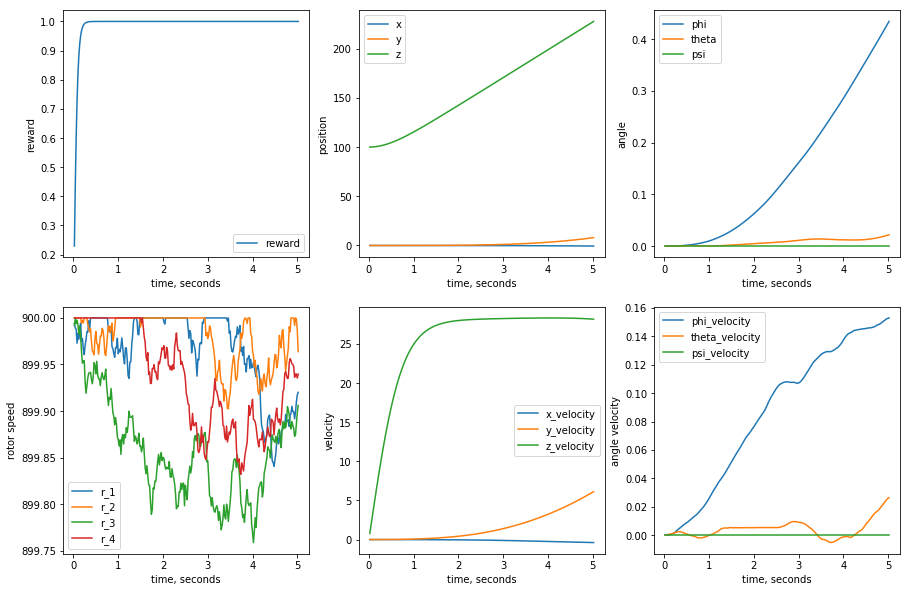

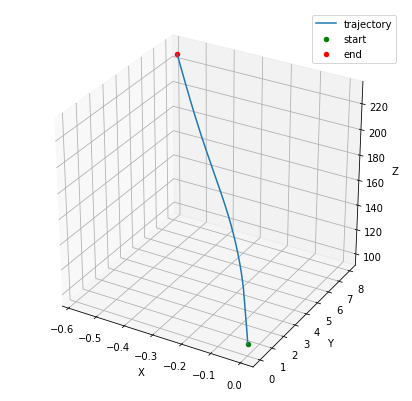

Start coordinates: x=  0.000 y=  0.000 z=100.008
End coordinates: x= -0.580 y=  7.971 z=227.703


In [7]:
state = agent.reset_episode() # start a new episode
plotter = Plotter()

while True:
    action = agent.act(state) 
    next_state, reward, done = task.step(action)
    
    # logging
    data_to_log = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward]
    plotter.add(data_to_log)
    
    agent.step(action, reward, next_state, done, is_learning=False)
    state = next_state
    if done:
        break
        
plotter.plot_all()
plotter.plot_trajectory()


## Reflections

### Question 1: Describe the task that you specified in task.py.  How did you design the reward function?

The task is to fly vertically upward. 

Initially I started with a complex reward function which contained several components. Namely, it endorsed the distance above the starting point across z-axis and positive vertical speed. Moreover, it penalized shifts across x and y directions, velocity in x and y directions and angle velocities. However, it turned out that it is very hard for an agent to learn such complex function because different components can compensate each other.

The next step was a simplification step where the reward function contained only two components: the distance between the starting and agent's position across z-axis and vertical speed. This reward function worked better but it was still sometimes misleading for the agent. Let's assume that at some point of time the distance between agent's position and starting point along z direction is -50 (means that agent moved down) and agent's vertical speed is +45. The final reward will be -5 but it actually should be positive because the agent actually moves upward. 

Taking into account all the above the final reward function takes into account only vertical speed. Z-velocity is scaled by a constant found empirically and squashed into the rage (-1,1) using tanh function which makes the process of neural network (NN) training better. Additionally, crushes are also penalized by giving the lowest possible reward of -1.


### Question 2: Discuss your agent briefly, using the following questions as a guide:

**- What learning algorithm(s) did you try? What worked best for you?**

I sticked to DDPG algorithm as it was recommended for the task and I wanted to look into the algorithm implementation details.

**- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)? What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.**

I have experimented with different neural network architectures. I started from the suggested architectures in the example code. Then I moved to the architecture suggested in the "Continuous control with deep reinforcement learning" paper. Finally, I landed somewhere in between. The actor's network has 3 fully connected (FC) layers with 64, 128 and 64 units respectively followed by a FC layer with unit number equals to action state space. The critic network is bit more complicated as it has both state and action as an input. State input is fed into two FC layers with 64 and 128 units and action input is fed into one FC layer with 128 units. The next layer sums the two small NN together. The critic's final layer is a FC layer which has 1 unit and output an estimated Q-value. Adam optimization algorithm was used with a learning rate of $10^{-7}$ and $10^{-5}$ for actor and critic respectively. The layer were initialized using Xavier initialization except the final layers. The final layers were initialized from a uniform distribution $[10^{-5}, 10^{5}]$ for actor and $[10^{-3}, 10^{3}]$ for critic. Both NNs used $L_2$ regularization with weight decay of $10^{-3}$. The discount factor $\gamma$ was chosen to be $0.99$ and for the soft update $\tau=0.01$ was used. The NNs were trained using minibatches of size 64 and a replay buffer of size $10^4$. For exploration purposes an Ornstein-Uhlenbeck process with $\mu=0$, $\theta=0.01$ and $\sigma=0.01$ was used.

### Question 3: Using the episode rewards plot, discuss how the agent learned over time.

**- Was it an easy task to learn or hard?**

**- Was there a gradual learning curve, or an aha moment?**

**- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)**


### Question 4: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

** - What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)**

**- Did you find anything interesting in how the quadcopter or your agent behaved?**
